In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
#from scipy.misc import imresize
from PIL import Image
import PIL

%matplotlib inline

import cv2
import seaborn as sns
import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

TypeError: 'AxesSubplot' object does not support indexing

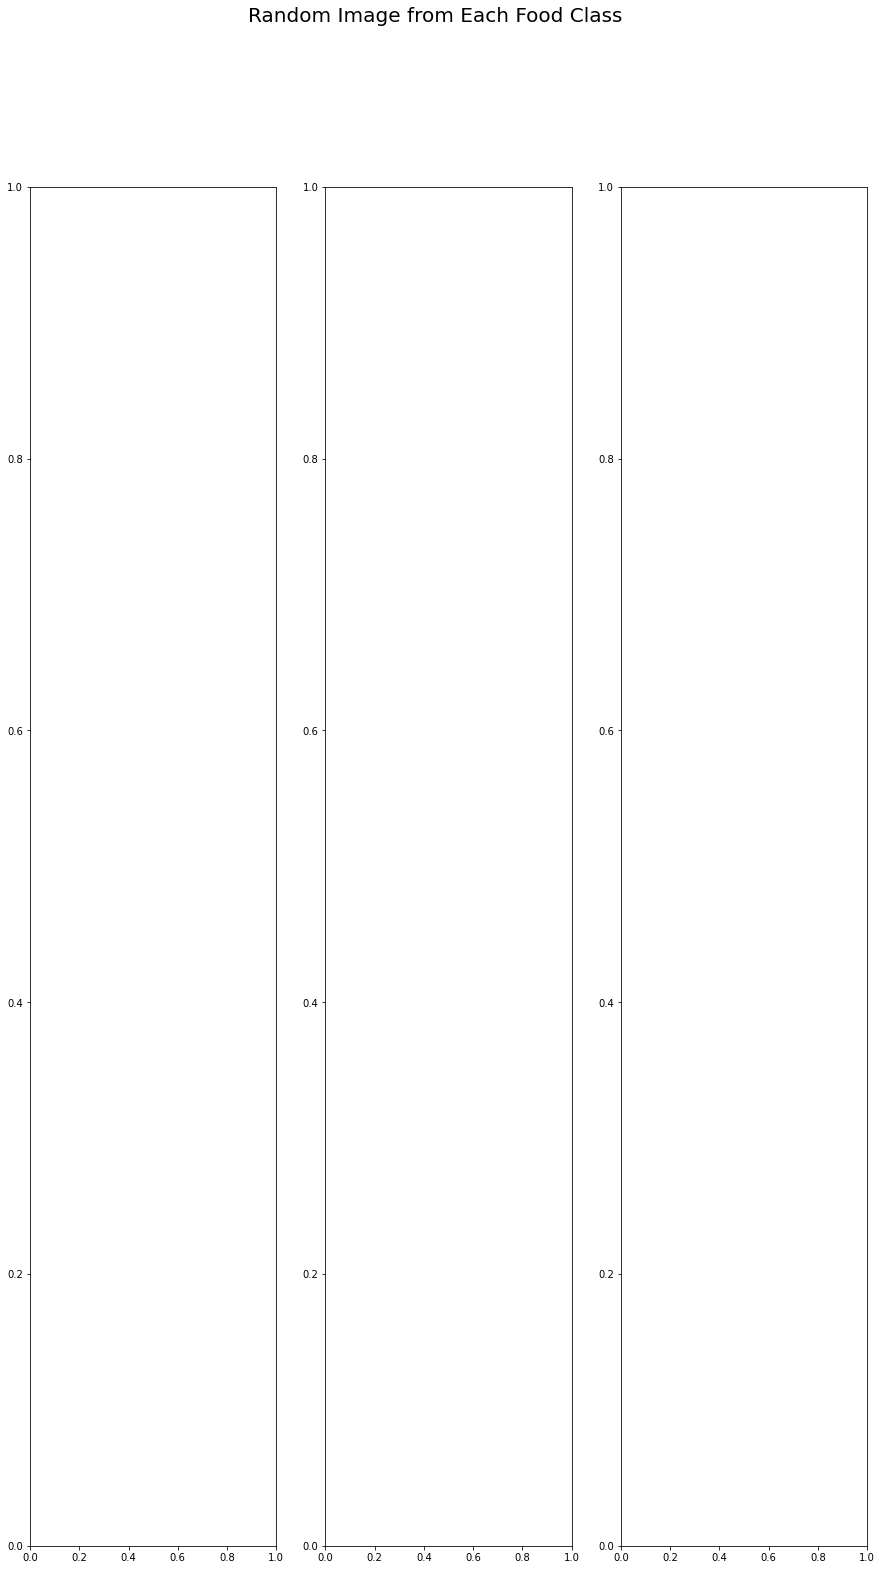

In [3]:
root_dir = './food-101/images/'
rows = 1
cols = 3
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
sorted_food_dirs.remove('.DS_Store')
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [2]:
import multiprocessing as mp

num_processes = 6
pool = mp.Pool(processes=num_processes)

In [3]:
class_to_ix = {}
ix_to_class = {}
with open('./food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

In [4]:
# Only split files if haven't already
if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('food-101/meta/train.txt')
    test_dir_files = generate_dir_file_map('food-101/meta/test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('food-101/images', 'food-101/test', ignore=ignore_train)
    copytree('food-101/images', 'food-101/train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

Train/Test files already copied into separate folders.


In [65]:
%%time

# Load dataset images and resize to meet minimum width and height pixel size
def load_images(root, min_side=299):
    all_imgs = []
    all_classes = []
    resize_count = 0
    invalid_count = 0
    for i, subdir in enumerate(listdir(root)):
        imgs = listdir(join(root, subdir))
        class_ix = class_to_ix[subdir]
        print(i, class_ix, subdir)
        for img_name in imgs:
            #img_arr = img.imread(join(root, subdir, img_name))
            img_arr = np.asarray(PIL.Image.open(join(root, subdir, img_name)))
            img_arr_rs = img_arr
            try:
                w, h, _ = img_arr.shape
                if w < min_side:
                    wpercent = (min_side/float(w))
                    hsize = int((float(h)*float(wpercent)))
                    #print('new dims:', min_side, hsize)
                    #img_arr_rs = imresize(img_arr, (min_side, hsize))
                    img_arr_rs = Image.fromarray(img_arr).resize(size=(hsize, min_side))
                    resize_count += 1
                elif h < min_side:
                    hpercent = (min_side/float(h))
                    wsize = int((float(w)*float(hpercent)))
                    #print('new dims:', wsize, min_side)
                    #img_arr_rs = imresize(img_arr, (wsize, min_side))
                    img_arr_rs = Image.fromarray(img_arr).resize(size=(hsize, min_side))
                    resize_count += 1
                all_imgs.append(img_arr_rs)
                all_classes.append(class_ix)
            except:
                print('Skipping bad image: ', subdir, img_name)
                invalid_count += 1
    print(len(all_imgs), 'images loaded')
    print(resize_count, 'images resized')
    print(invalid_count, 'images skipped')
    return np.array(all_imgs), np.array(all_classes)
    
X_test, y_test = load_images('./food-101/test', min_side=299)

0 2 waffles
Skipping bad image:  waffles 3798963.jpg
1 0 apple_pie
2 1 pizza
749 images loaded
14 images resized
1 images skipped
CPU times: user 2.45 s, sys: 379 ms, total: 2.83 s
Wall time: 3.03 s


/Users/prat/opt/anaconda3/envs/shazamEnv/lib/python3.7/site-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [66]:
%%time
X_train, y_train = load_images('./food-101/train', min_side=299)

0 2 waffles
1 0 apple_pie
2 1 pizza
2250 images loaded
58 images resized
0 images skipped
CPU times: user 7.63 s, sys: 1.24 s, total: 8.87 s
Wall time: 9.56 s


/Users/prat/opt/anaconda3/envs/shazamEnv/lib/python3.7/site-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [5]:
labels = ['apple_pie', 'pizza','waffles']
img_size = 299
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)
train = get_data('./food-101/train/')
val = get_data('./food-101/test')
x_train = []
y_train = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_test.append(feature)
    y_test.append(label)

/Users/prat/opt/anaconda3/envs/shazamEnv/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


In [6]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)
x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)
print('X_train shape', x_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', x_test.shape)
print('y_test shape', y_test.shape)

X_train shape (2250, 299, 299, 3)
y_train shape (2250,)
X_test shape (750, 299, 299, 3)
y_test shape (750,)


In [7]:
@interact(n=(0, len(X_train)))
def show_pic(n):
    plt.imshow(X_train[n])
    print('class:', y_train[n], ix_to_class[y_train[n]])

NameError: name 'X_train' is not defined

In [69]:
@interact(n_class=sorted_class_to_ix)
def show_random_images_of_class(n_class=0):
    print(n_class)
    nrows = 1
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(12, 8)
    #fig.tight_layout()
    imgs = np.random.choice((y_train == n_class).nonzero()[0], nrows * ncols)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(X_train[imgs[i]])
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
    plt.subplots_adjust(left=0, wspace=0, hspace=0)
    plt.show()

interactive(children=(Dropdown(description='n_class', options=OrderedDict([('apple_pie', 0), ('pizza', 1), ('w…

In [9]:
@interact(n_class=sorted_class_to_ix)
def show_random_images_of_class(n_class=0):
    print(n_class)
    nrows = 4
    ncols = 8
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(12, 8)
    #fig.tight_layout()
    imgs = np.random.choice((y_test == n_class).nonzero()[0], nrows * ncols)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(X_test[imgs[i]])
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
    plt.subplots_adjust(left=0, wspace=0, hspace=0)
    plt.show()

interactive(children=(Dropdown(description='n_class', options=OrderedDict([('apple_pie', 0), ('pizza', 1), ('w…

In [8]:
from keras.utils.np_utils import to_categorical

n_classes = 3
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

In [9]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input
from keras.preprocessing.image import ImageDataGenerator

#import tools.image_gen_extended as T

In [10]:
#Stratospark code

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False, # randomly flip images
    zoom_range=[.8, 1],
    channel_shift_range=30,
    fill_mode='reflect')
#train_datagen.config['random_crop_size'] = (299, 299)
#train_datagen.set_pipeline([T.random_transform, T.random_crop, T.preprocess_input])
train_generator = train_datagen.flow(x_train, y_train_cat, batch_size=64, seed=11)

In [11]:
test_datagen = ImageDataGenerator()
#test_datagen.config['random_crop_size'] = (299, 299)
#test_datagen.set_pipeline([T.random_transform, T.random_crop, T.preprocess_input])
test_generator = test_datagen.flow(x_test, y_test_cat, batch_size=64, seed=11)

In [12]:
def reverse_preprocess_input(x0):
    x = x0 / 2.0
    x += 0.5
    x *= 255.
    return x

In [13]:
%%time
@interact()
def show_images(unprocess=True):
    for x in test_generator:
        fig, axes = plt.subplots(nrows=8, ncols=4)
        fig.set_size_inches(8, 8)
        page = 0
        page_size = 32
        start_i = page * page_size
        for i, ax in enumerate(axes.flat):
            img = x[0][i+start_i]
            if unprocess:
                im = ax.imshow( reverse_preprocess_input(img).astype('uint8') )
            else:
                im = ax.imshow(img)
            ax.set_axis_off()
            ax.title.set_visible(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)

        plt.subplots_adjust(left=0, wspace=0, hspace=0)
        plt.show()
        break

interactive(children=(Checkbox(value=True, description='unprocess'), Output()), _dom_classes=('widget-interact…

CPU times: user 1.46 s, sys: 151 ms, total: 1.62 s
Wall time: 1.22 s


In [15]:
%%time
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math

K.clear_session()

base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
x = base_model.output
x = AveragePooling2D(pool_size=(8, 8))(x)
x = Dropout(.4)(x)
x = Flatten()(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(base_model.input, predictions)

opt = SGD(lr=.01, momentum=.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model4.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model4.log')

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)

model.fit(train_generator,
                    validation_data=test_generator,
                    validation_steps=x_test.shape[0],
                    steps_per_epoch=x_train.shape[0],
                    epochs=32,
                    verbose=2,
                    callbacks=[lr_scheduler, csv_logger, checkpointer])

Epoch 1/32

Epoch 00001: val_loss improved from inf to 2.28852, saving model to model4.01-2.29.hdf5
  36/2250 - 831s - loss: 0.5228 - accuracy: 0.7911 - val_loss: 2.2885 - val_accuracy: 0.3933 - lr: 0.0100
CPU times: user 45min 14s, sys: 5min 33s, total: 50min 48s
Wall time: 14min 33s


In [16]:
model.save('./shazamInception/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./shazamInception/assets


In [18]:
def getFinalPredictions(dataDir):
    data = []
    img_size=299
    img_arr = cv2.imread(dataDir)[...,::-1] #convert BGR to RGB format
    resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
    data.append(resized_arr)
    return np.array(data)

In [33]:
finalImage = getFinalPredictions('./testFolder/116705.jpg')
finalImage.reshape(-1, 299, 299, 1)
predictionsImage = model.predict(finalImage)

In [34]:
predictionsImage

array([[1.1167992e-01, 7.7209220e-04, 8.8754797e-01]], dtype=float32)